# Task 1 - Setup

In [341]:
import warnings
#STEP 1: Import the libraries and set the random seed.
import numpy as np
import pdb
import folktables
import time
import pandas as pd


warnings.filterwarnings(action = "ignore")
# warnings.filterwarnings(action = "ignore", message="`load_boston` has been removed from scikit-learn since version 1.2")

from folktables import ACSDataSource
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

# Modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
from sklearn.metrics import accuracy_score
from scipy.stats import randint
np.random.seed(0)

# Step 2: Load the datasets
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
features=[
'AGEP', #age; for range of values of features please check Appendix B.4 of Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
'SCHL', #educational attainment
'MAR', #marital status
'RELP', #relationship
'DIS', #disability recode
'ESP', #employment status of parents
'CIT', #citizenship status
'MIG', #mobility status (lived here 1 year ago)
'MIL', #military service
'ANC', #ancestry recode
'NATIVITY', #nativity
'DEAR', #hearing difficulty
'DEYE', #vision difficulty
'DREM', #cognitive difficulty
'SEX', #sex
'RAC1P', #recoded detailed race code
'GCL', #grandparents living with grandchildren
],
target='ESR', #employment status recode
target_transform=lambda x: x == 1,
group='DIS',
preprocess=employment_filter,
postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

from aif360.datasets import StandardDataset

data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
            protected_attribute_names = protected_attribute_names,
            privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 2}]
unprivileged_groups = [{'DIS': 1}]

dataset_before_split = data_for_aif.features.shape[0]
# print("dataset_before_split:", dataset_before_split)

test_train_datasets = data_for_aif.split([int(dataset_before_split*0.7)], shuffle = True)

#Normalize the dataset, train, val, and test
scale_orig = StandardScaler()

temporary_train_dataset = test_train_datasets[0]
X_train = scale_orig.fit_transform(temporary_train_dataset.features)
y_train = temporary_train_dataset.labels.ravel()


test_dataset = test_train_datasets[1]
X_test = scale_orig.transform(test_dataset.features)
y_test = test_dataset.labels.ravel()

# print("data:", data)
# print("len(data):", len(data))


def gen_multiple_train_val(temporary_train_dataset, total_sets_wanted: int, train_prop: float):
    training_sets_dict = dict()
    validation_sets_dict = dict()
    overall_train = dict()
    overall_val = dict()
    
    """Repeats the procedure of splitting train set into train-train/train-val sets 4 more times (make sure you shuffle the train data before you repeat this procedure). In the end, you should have 5 sets of train-train/train-val data splits."""
    for set in range(1, total_sets_wanted+1):
        dataset_before_split = temporary_train_dataset.features.shape[0]
        train_val_datasets = temporary_train_dataset.split([int(dataset_before_split*train_prop)], shuffle = True)
        #Normalize the dataset, train, val, and test
        scale_orig = StandardScaler()
        
        X_train = scale_orig.fit_transform(train.features)
        y_train = train.labels.ravel()

        X_val = scale_orig.transform(val.features)
        y_val = val.labels.ravel()
        
        training_sets_dict[set] = [X_train, y_train]
        validation_sets_dict[set] = [X_val, y_val]
        overall_val[set] = train_val_datasets[1]
        overall_train[set] = train_val_datasets[0]
    return overall_train, training_sets_dict, overall_val, validation_sets_dict


# Further iterations of training & validation data
overall_train, training_sets_dict, overall_val, validation_sets_dict = gen_multiple_train_val(temporary_train_dataset, 5, 0.8)

In [342]:
# Error handling - distribution testing
print("Training dataset shape:", temporary_train_dataset.features.shape)
print("Training labels shape:", temporary_train_dataset.labels.shape)
print("Test dataset shape:", test_dataset.features.shape)
print("Test labels shape:", test_dataset.labels.shape)

# print("Training dataset basic stats:", pd.DataFrame(temporary_train_dataset.features).describe())
# print("Test dataset basic stats:", pd.DataFrame(test_dataset.features).describe())

Training dataset shape: (117114, 17)
Training labels shape: (117114, 1)
Test dataset shape: (50192, 17)
Test labels shape: (50192, 1)


## Tasks 1.b & 1.c - Accuracy and Fairness tested

In [343]:
# Hyperparameter tuning
C_parameters = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
solvers = ['liblinear', 'sag', 'saga']

def use_log_reg_model(temporary_train_dataset):
    param_dict = {}
    Averaged_param_dict = {}

    for c_param in C_parameters:
        param_dict[c_param] = {}
        Averaged_param_dict[c_param] = {}

        for solver in solvers:
#             print(f"Starting evaluation of set C = {c_param} and solver = {solver}")
            param_dict[c_param][solver] = {
                'Accuracy': [],
                'stat_par_diff': [],
                'eq_opp_diff': []
            }
        
            for i in range(1, len(training_sets_dict.items())+1):
                X_train = training_sets_dict[i][0]
                y_train = training_sets_dict[i][1]
                X_val = validation_sets_dict[i][0]
                y_val = validation_sets_dict[i][1]

                learner = LogisticRegression(C=c_param, solver=solver, random_state=1)
                learner.fit(X_train, y_train)
                predictions = learner.predict(X_val)

                # Metrics calculation
                Accuracy = sum(predictions == y_val) / len(y_val)
                param_dict[c_param][solver]['Accuracy'].append(Accuracy)

                val_pred = overall_val[i].copy()
                val_pred.labels = predictions
                metric = ClassificationMetric(overall_val[i], val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
                param_dict[c_param][solver]['stat_par_diff'].append(metric.statistical_parity_difference())
                param_dict[c_param][solver]['eq_opp_diff'].append(metric.equal_opportunity_difference())

            # Averaging metrics for each C & (?) solver
            Averaged_param_dict[c_param][solver] = {
                'Accuracy': sum(param_dict[c_param][solver]['Accuracy']) / len(training_sets_dict.items()),
                'stat_par_diff': sum(param_dict[c_param][solver]['stat_par_diff']) / len(training_sets_dict.items()),
                'eq_opp_diff': sum(param_dict[c_param][solver]['eq_opp_diff']) / len(training_sets_dict.items())
            }
#             print(f"Averaged metrics for C = {c_param} and solver = {solver}:", Averaged_param_dict[c_param][solver])

    return Averaged_param_dict, param_dict

Averaged_param_dict, param_dict = use_log_reg_model(temporary_train_dataset)

# print("param_dict['eq_opp_diff']:", param_dict)


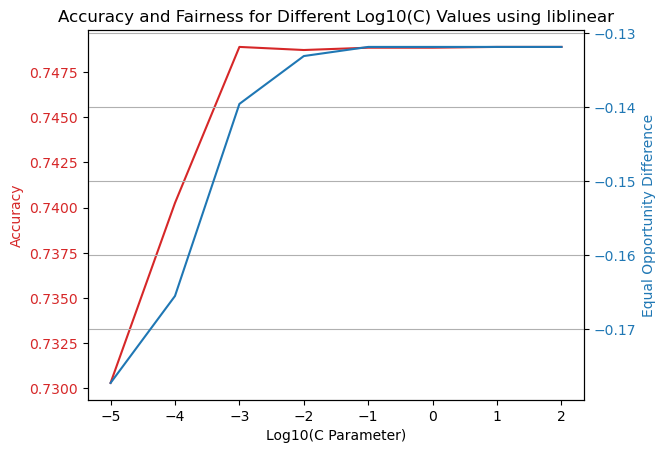

In [344]:
# Plotting the data
C_values = C_parameters  # List of C parameters
log_C_values = np.log10(C_values)
liblinear_accuracy = [Averaged_param_dict[C]['liblinear']['Accuracy'] for C in C_values]
liblinear_eop = [Averaged_param_dict[C]['liblinear']['eq_opp_diff'] for C in C_values]

# Create the plot
fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:red'
ax1.set_xlabel('Log10(C Parameter)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(log_C_values, liblinear_accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Equal Opportunity Difference', color=color)  
ax2.plot(log_C_values, liblinear_eop, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy and Fairness for Different Log10(C) Values using liblinear')
plt.grid(True)
plt.show()

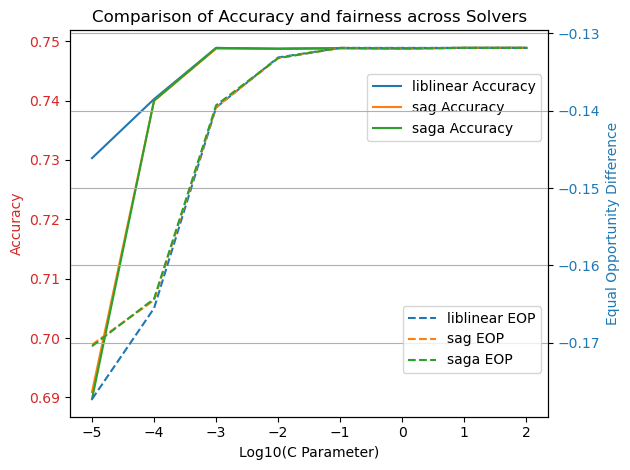

In [345]:
# Example for one other solver - sag
sag_accuracy = [Averaged_param_dict[C]['sag']['Accuracy'] for C in C_values]
sag_eop = [Averaged_param_dict[C]['sag']['eq_opp_diff'] for C in C_values]
saga_accuracy = [Averaged_param_dict[C]['saga']['Accuracy'] for C in C_values]
saga_eop = [Averaged_param_dict[C]['saga']['eq_opp_diff'] for C in C_values]

# Create the plot
fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:red'
ax1.set_xlabel('Log10(C Parameter)')
ax1.set_ylabel('Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(log_C_values, liblinear_accuracy, label='liblinear Accuracy')
ax1.plot(log_C_values, sag_accuracy, label='sag Accuracy')
ax1.plot(log_C_values, saga_accuracy, label='saga Accuracy')

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Equal Opportunity Difference', color=color)  
ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(log_C_values, liblinear_eop, label='liblinear EOP', linestyle='--')
ax2.plot(log_C_values, sag_eop, label='sag EOP', linestyle='--')
ax2.plot(log_C_values, saga_eop, label='saga EOP', linestyle='--')

ax1.legend(loc='center right', bbox_to_anchor=(1, 0.8))
ax2.legend(loc='center right', bbox_to_anchor=(1, 0.2))

plt.xlabel('Log(C) Parameter')
plt.title('Comparison of Accuracy and fairness across Solvers')

plt.tight_layout()
plt.grid(True)
plt.show()

In [346]:
# Selecting the model with the highest accuracy for use on the test set
best_model_index = np.argmax(composite_scores)
best_C, best_solver = [(C, solver) for C in C_parameters for solver in solvers][best_model_index]

print(f"The standard best model is with C = {best_C} and solver = {best_solver}")


The standard best model is with C = 1e-05 and solver = liblinear


In [347]:
import pandas as pd

def tabulate_results(results):
    # Initialize a list to hold the tabulated data
    tabulated_data = []

    # Iterate over the results to populate the tabulated_data list
    for c_value, solvers in results.items():
        for solver, metrics in solvers.items():
            row = {
                'C Value': c_value,
                'Solver': solver,
                'Accuracy': metrics['Accuracy'],
                'Equal Opportunity Difference': metrics['eq_opp_diff']
            }
            tabulated_data.append(row)

    # Create a DataFrame from the tabulated data
    df = pd.DataFrame(tabulated_data)
    return df

df_standard = tabulate_results(Averaged_param_dict)
# print("df_standard:\n", df_standard)

In [348]:
# Find and test best model function
best_accuracy_model_std = df_standard.sort_values(by='Accuracy', ascending=False).head(1)
best_fairness_model_std = df_standard.assign(Eq_Opp_Diff_Abs = abs(df_standard['Equal Opportunity Difference'])).sort_values(by='Eq_Opp_Diff_Abs').head(1)

print("Best Accuracy Model - Standard:")
print(best_accuracy_model_std)
print("\nBest Fairness Model - Standard:")
print(best_fairness_model_std)


Best Accuracy Model - Standard:
    C Value Solver  Accuracy  Equal Opportunity Difference
23    100.0   saga  0.748879                     -0.131869

Best Fairness Model - Standard:
    C Value     Solver  Accuracy  Equal Opportunity Difference  \
15      1.0  liblinear  0.748837                     -0.131869   

    Eq_Opp_Diff_Abs  
15         0.131869  


In [349]:
# For this standard model - return accuracy and fairness metrics for the most accurate model, amd the most fair.
# Extracting hyperparameters for the best accuracy model
best_accuracy_hyperparams = {
    'C': best_accuracy_model_std['C Value'].values[0],
    'solver': best_accuracy_model_std['Solver'].values[0]
}

# Extracting hyperparameters for the best fairness model
best_fairness_hyperparams = {
    'C': best_fairness_model_std['C Value'].values[0],
    'solver': best_fairness_model_std['Solver'].values[0]
}


## Compute Test set accuracies for:
1. Standard, most acc.
2. Standard most Fair


In [350]:
def train_and_test_model(X_train, y_train, X_test, y_test, hyperparameters):
    """
    Trains a logistic regression model using given hyperparameters and evaluates it on the test set.

    :param X_train: Features of the training dataset
    :param y_train: Labels of the training dataset
    :param X_test: Features of the test dataset
    :param y_test: Labels of the test dataset
    :param hyperparameters: Dictionary containing 'C' and 'solver' for the model
    :return: A dictionary containing accuracy and equal opportunity difference of the model on the test set
    """
    # Initialize logistic regression model with the provided hyperparameters
    model = LogisticRegression(C=hyperparameters['C'], solver=hyperparameters['solver'], random_state=1)
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)

    # Prepare test dataset for fairness metrics calculation
    test_dataset_for_fairness = test_dataset.copy()
    test_dataset_for_fairness.labels = predictions.reshape(-1,1)

    # Calculate equal opportunity difference
    metric = ClassificationMetric(test_dataset, test_dataset_for_fairness, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = metric.equal_opportunity_difference()

    return {'Accuracy': accuracy, 'Equal Opportunity Difference': eq_opp_diff}

# Using the function for best accuracy hyperparameters
results_accuracy = train_and_test_model(X_train, y_train, X_test, y_test, best_accuracy_hyperparams)
print("Results for Best Accuracy Model:")
print(results_accuracy)

# Using the function for best fairness hyperparameters
results_fairness = train_and_test_model(X_train, y_train, X_test, y_test, best_fairness_hyperparams)
print("Results for Best Fairness Model:")
print(results_fairness)

Results for Best Accuracy Model:
{'Accuracy': 0.7530881415364998, 'Equal Opportunity Difference': -0.6178534973774716}
Results for Best Fairness Model:
{'Accuracy': 0.7530881415364998, 'Equal Opportunity Difference': -0.6178937485447555}


# Tasks 2.a & 2.b - Accuracy and Fairness tested after Reweighting

In [351]:
# Hyperparameter tuning with Reweighting
C_parameters = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
solvers = ['liblinear', 'sag', 'saga']

# Further iterations of training & validation data
overall_train, training_sets_dict, overall_val, validation_sets_dict = gen_multiple_train_val(temporary_train_dataset, 5, 0.8)

def use_log_reg_model_w_reweighting(temporary_train_dataset):
    param_dict = {}
    Averaged_param_dict = {}

    for c_param in C_parameters:
        param_dict[c_param] = {}
        Averaged_param_dict[c_param] = {}

        for solver in solvers:
#             print(f"Starting evaluation of set C = {c_param} and solver = {solver}")
            param_dict[c_param][solver] = {
                'Accuracy': [],
                'stat_par_diff': [],
                'eq_opp_diff': []
            }
        
            for i in range(1, len(training_sets_dict.items())+1):
                X_val = validation_sets_dict[i][0]
                y_val = validation_sets_dict[i][1]
                
                train = overall_train[i]
                val = overall_val[i]
                
                # Transforming the original dataset via reweighing
                RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
                #We obtain a set of weights for the training set, to use in scikit-learn.
                train = RW.fit_transform(train)

#                 print("subgroup weights", np.unique(train.instance_weights))

                X_train = scale_orig.fit_transform(train.features)
                y_train = train.labels.ravel()
                
                learner = LogisticRegression(C=c_param, solver=solver, random_state=1)
                learner.fit(X_train, y_train)
                predictions = learner.predict(X_val)

                # Metrics calculation
                Accuracy = sum(predictions == y_val) / len(y_val)
                param_dict[c_param][solver]['Accuracy'].append(Accuracy)

                val_pred = overall_val[i].copy()
                val_pred.labels = predictions
                metric = ClassificationMetric(overall_val[i], val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
                param_dict[c_param][solver]['stat_par_diff'].append(metric.statistical_parity_difference())
                param_dict[c_param][solver]['eq_opp_diff'].append(metric.equal_opportunity_difference())


            # Averaging metrics for each solver
            Averaged_param_dict[c_param][solver] = {
                'Accuracy': sum(param_dict[c_param][solver]['Accuracy']) / len(training_sets_dict.items()),
                'stat_par_diff': sum(param_dict[c_param][solver]['stat_par_diff']) / len(training_sets_dict.items()),
                'eq_opp_diff': sum(param_dict[c_param][solver]['eq_opp_diff']) / len(training_sets_dict.items())
            }
#             print(f"Averaged metrics for C = {c_param} and solver = {solver}:", Averaged_param_dict[c_param][solver])

    return Averaged_param_dict

Reweighted_averaged_param_dict = use_log_reg_model_w_reweighting(temporary_train_dataset)


In [352]:
def rewighted_tabulate_results(results):
    # Initialize a list to hold the tabulated data
    tabulated_data = []

    # Iterate over the results to populate the tabulated_data list
    for c_value, solvers in results.items():
        for solver, metrics in solvers.items():
            row = {
                'C Value': c_value,
                'Solver': solver,
                'Accuracy': metrics['Accuracy'],
                'Equal Opportunity Difference': metrics['eq_opp_diff']
            }
            tabulated_data.append(row)

    # Create a DataFrame from the tabulated data
    df = pd.DataFrame(tabulated_data)
    return df

df_reweighted = tabulate_results(Reweighted_averaged_param_dict)
# print("df_reweighted\n", df_reweighted)

In [353]:
# Find the best models for the reweighted approach

best_accuracy_model_reweighted = df_reweighted.sort_values(by='Accuracy', ascending=False).head(1)
best_fairness_model_reweighted = df_reweighted.assign(Eq_Opp_Diff_Abs = abs(df_reweighted['Equal Opportunity Difference'])).sort_values(by='Eq_Opp_Diff_Abs').head(1)

print("\nBest Accuracy Model - Reweighted:")
print(best_accuracy_model_reweighted)
print("\nBest Fairness Model - Reweighted:")
print(best_fairness_model_reweighted)

# Extracting hyperparameters for the best accuracy model
best_acc_hyperparams_reweighted = {
    'C': best_accuracy_model_reweighted['C Value'].values[0],
    'solver': best_accuracy_model_reweighted['Solver'].values[0]
}

# Extracting hyperparameters for the best fairness model
best_fair_hyperparams_reweighted = {
    'C': best_fairness_model_reweighted['C Value'].values[0],
    'solver': best_fairness_model_reweighted['Solver'].values[0]
}



Best Accuracy Model - Reweighted:
    C Value Solver  Accuracy  Equal Opportunity Difference
10     0.01    sag  0.748956                      0.003143

Best Fairness Model - Reweighted:
   C Value Solver  Accuracy  Equal Opportunity Difference  Eq_Opp_Diff_Abs
5   0.0001   saga  0.739965                      0.000181         0.000181


## Compute Test set accuracies for:

1. Reweighted most acc.
2. Reweighted most fair

In [354]:
def train_and_test_model_reweighted(X_train, y_train, X_test, y_test, train_dataset, hyperparameters):
    """
    Trains a logistic regression model with reweighting using given hyperparameters and evaluates it on the test set.

    :param X_train: Features of the training dataset
    :param y_train: Labels of the training dataset
    :param X_test: Features of the test dataset
    :param y_test: Labels of the test dataset
    :param train_dataset: Original training dataset before feature scaling for reweighting
    :param hyperparameters: Dictionary containing 'C' and 'solver' for the model
    :return: A dictionary containing accuracy and equal opportunity difference of the model on the test set
    """
    # Apply reweighting to the training dataset
    RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    train_dataset = RW.fit_transform(train_dataset)

    # Extract the reweighted labels and instance weights
    y_train = train_dataset.labels.ravel()
    instance_weights = train_dataset.instance_weights

    # Initialize logistic regression model with the provided hyperparameters
    model = LogisticRegression(C=hyperparameters['C'], solver=hyperparameters['solver'], random_state=1)
    
    # Train the model with instance weights
    model.fit(X_train, y_train, sample_weight=instance_weights)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)

    # Prepare test dataset for fairness metrics calculation
    test_dataset_for_fairness = test_dataset.copy()
    test_dataset_for_fairness.labels = predictions.reshape(-1,1)

    # Calculate equal opportunity difference
    metric = ClassificationMetric(test_dataset, test_dataset_for_fairness, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = metric.equal_opportunity_difference()

    return {'Accuracy': accuracy, 'Equal Opportunity Difference': eq_opp_diff}

# Using the function for best accuracy hyperparameters with reweighting
results_accuracy_reweighted = train_and_test_model_reweighted(X_train, y_train, X_test, y_test, temporary_train_dataset, best_acc_hyperparams_reweighted)
print("Results for Best Accuracy Model - Reweighted:")
print(results_accuracy_reweighted)

# Using the function for best fairness hyperparameters with reweighting
results_fairness_reweighted = train_and_test_model_reweighted(X_train, y_train, X_test, y_test, temporary_train_dataset, best_fair_hyperparams_reweighted)
print("Results for Best Fairness Model - Reweighted:")
print(results_fairness_reweighted)


Results for Best Accuracy Model - Reweighted:
{'Accuracy': 0.7190388906598661, 'Equal Opportunity Difference': -0.0014426838429895117}
Results for Best Fairness Model - Reweighted:
{'Accuracy': 0.7202940707682499, 'Equal Opportunity Difference': -0.0317568993511127}


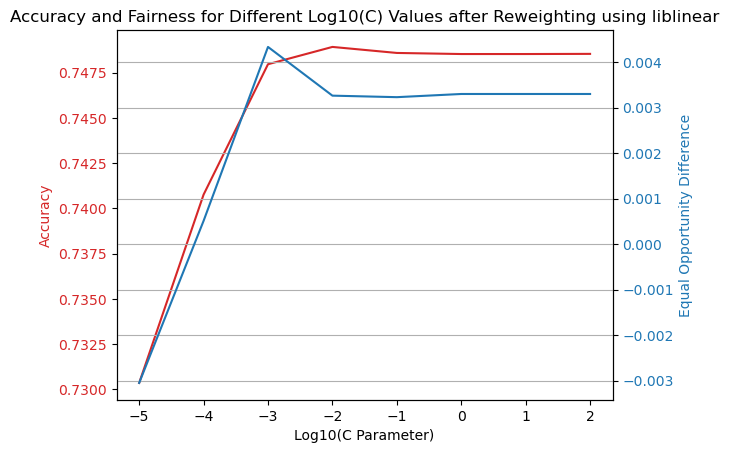

In [355]:
# Reqighted data C value plotting
# Extract data for plotting
C_values = C_parameters  # List of C parameters
# print("C_parameters:", C_parameters)
log_C_values = np.log10(C_values) 
liblinear_accuracy = [Reweighted_averaged_param_dict[C]['liblinear']['Accuracy'] for C in C_values]
liblinear_eop = [Reweighted_averaged_param_dict[C]['liblinear']['eq_opp_diff'] for C in C_values]

# Create the plot
fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:red'
ax1.set_xlabel('Log10(C Parameter)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(log_C_values, liblinear_accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Equal Opportunity Difference', color=color)  
ax2.plot(log_C_values, liblinear_eop, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Accuracy and Fairness for Different Log10(C) Values after Reweighting using liblinear')
plt.grid(True)

plt.show()

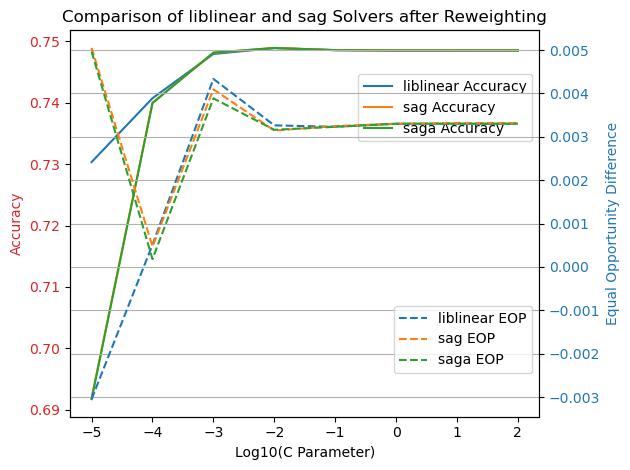

In [356]:
sag_accuracy = [Reweighted_averaged_param_dict[C]['sag']['Accuracy'] for C in C_values]
sag_eop = [Reweighted_averaged_param_dict[C]['sag']['eq_opp_diff'] for C in C_values]
saga_accuracy = [Reweighted_averaged_param_dict[C]['saga']['Accuracy'] for C in C_values]
saga_eop = [Reweighted_averaged_param_dict[C]['saga']['eq_opp_diff'] for C in C_values]

# Create the plot
fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:red'
ax1.set_xlabel('Log10(C Parameter)')
ax1.set_ylabel('Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax1.plot(log_C_values, liblinear_accuracy, label='liblinear Accuracy')
ax1.plot(log_C_values, sag_accuracy, label='sag Accuracy')
ax1.plot(log_C_values, saga_accuracy, label='saga Accuracy')


ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Equal Opportunity Difference', color=color)  
ax2.tick_params(axis='y', labelcolor=color)


ax2.plot(log_C_values, liblinear_eop, label='liblinear EOP', linestyle='--')
ax2.plot(log_C_values, sag_eop, label='sag EOP', linestyle='--')
ax2.plot(log_C_values, saga_eop, label='saga EOP', linestyle='--')

ax1.legend(loc='center right', bbox_to_anchor=(1, 0.8))
ax2.legend(loc='center right', bbox_to_anchor=(1, 0.2))


plt.xlabel('Log(C) Parameter')
plt.title('Comparison of liblinear and sag Solvers after Reweighting')

plt.tight_layout()
plt.grid(True)
plt.show()

# Task 3a: Standard Model Selection

In [357]:
def is_pareto_efficient_simple(costs):
    """
    Find the Pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A Boolean array denoting Pareto efficiency of points
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
             # Keep any point with a lower cost
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) 
            # And keep self
            is_efficient[i] = True
    return is_efficient


Apply Criterion to Standard Models:
1. Using my combined metric, evaluate each standard model (pre-reweighting) using the 5 sets of train-train/train-val data splits.
    
2. Vary the hyperparameters (in this case, the C value and the choice of solver) and select the model that performs best according to criterion.

In [358]:
# Calculate Pareto Efficiency for the std models first
accuracy_values_std = [Averaged_param_dict[C][solver]['Accuracy'] for C in C_parameters for solver in solvers]
fairness_values_std = [Averaged_param_dict[C][solver]['eq_opp_diff'] for C in C_parameters for solver in solvers]

# Combining accuracy and fairness values into a single array (note that fairness is multiplied by -1 to convert it into a cost)
costs = np.column_stack((-np.array(accuracy_values_std), np.array(fairness_values_std)))

# Identifying Pareto efficient coefficient combinations
pareto_efficient = is_pareto_efficient_simple(costs)

# Extracting hyperparameters
std_pareto_models = [(C_parameters[i // len(solvers)], solvers[i % len(solvers)], accuracy_values_std[i], fairness_values_std[i]) for i in range(len(accuracy_values_std)) if pareto_efficient[i]]

# for model in std_pareto_models:
#     print(f"C: {model[0]}, Solver: {model[1]}, Accuracy: {model[2]}, Equal Opportunity Difference: {model[3]}")

# For standard Model
std_best_pareto_model =  min(std_pareto_models, key=lambda x: abs(x[3])) 
print("Best Pareto Efficient Standard Model:")
print(f"C: {std_best_pareto_model[0]}, Solver: {std_best_pareto_model[1]}, Accuracy: {std_best_pareto_model[2]}, Equal Opportunity Difference: {std_best_pareto_model[3]}")


Best Pareto Efficient Standard Model:
C: 0.001, Solver: liblinear, Accuracy: 0.7488793066643897, Equal Opportunity Difference: -0.13957645942697508


Apply Criterion to Fairness-Aware Models:

 1. Repeat the same process for the fairness-aware models (post-reweighting).

In [359]:
# Calculate the Pareto Efficiency for the fair aware models 
accuracy_values_rew = [Reweighted_averaged_param_dict[C][solver]['Accuracy'] for C in C_parameters for solver in solvers]
fairness_values_rew = [Reweighted_averaged_param_dict[C][solver]['eq_opp_diff'] for C in C_parameters for solver in solvers]

# Combining accuracy and fairness values into a single array (note that fairness is multiplied by -1 to convert it into a cost)
reweighted_costs = np.column_stack((-np.array(accuracy_values_rew), np.array(fairness_values_rew)))

# Identifying Pareto efficient coefficient combinations
reweighted_pareto_efficient = is_pareto_efficient_simple(reweighted_costs)

# Extracting hyperparameters
reweighted_pareto_models = [(C_parameters[i // len(solvers)], solvers[i % len(solvers)], accuracy_values_rew[i], fairness_values_rew[i]) for i in range(len(accuracy_values_rew)) if reweighted_pareto_efficient[i]]

# for model in reweighted_pareto_models:
#     print(f"C: {model[0]}, Solver: {model[1]}, Accuracy: {model[2]}, Equal Opportunity Difference: {model[3]}")

# For fair aware Model
rew_best_pareto_model = min(reweighted_pareto_models, key=lambda x: abs(x[3])) 
print("Best Pareto Efficient Fairness-aware Model:")
print(f"C: {rew_best_pareto_model[0]}, Solver: {rew_best_pareto_model[1]}, Accuracy: {rew_best_pareto_model[2]}, Equal Opportunity Difference: {rew_best_pareto_model[3]}")

Best Pareto Efficient Fairness-aware Model:
C: 0.0001, Solver: saga, Accuracy: 0.7399649916748496, Equal Opportunity Difference: 0.00018101355902959692


Compute Test set accuracies for:
1. Selected criterion most acc
2. Selecter criterian most fair.

In [360]:
# Function to train and test the model
def train_and_test_model(X_train, y_train, X_test, y_test, hyperparameters):
    # Initialize and train the logistic regression model
    model = LogisticRegression(C=hyperparameters['C'], solver=hyperparameters['solver'], random_state=1)
    model.fit(X_train, y_train)

    # Make predictions and evaluate on the test set
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    test_dataset_for_fairness = test_dataset.copy()
    test_dataset_for_fairness.labels = predictions.reshape(-1,1)
    metric = ClassificationMetric(test_dataset, test_dataset_for_fairness, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = metric.equal_opportunity_difference()

    return {'Accuracy': accuracy, 'Equal Opportunity Difference': eq_opp_diff}

# Best hyperparameters for Standard Model
best_std_hyperparams = {'C': std_best_pareto_model[0], 'solver': std_best_pareto_model[1]}
# Evaluate on test set
results_std = train_and_test_model(X_train, y_train, X_test, y_test, best_std_hyperparams)
print("Test Results for Best Standard Model (Pareto Efficient):")
print(results_std)

# Best hyperparameters for Reweighted Model
best_rew_hyperparams = {'C': rew_best_pareto_model[0], 'solver': rew_best_pareto_model[1]}
# Train and test the model with reweighting
results_rew = train_and_test_model_reweighted(X_train, y_train, X_test, y_test, temporary_train_dataset, best_rew_hyperparams)
print("Test Results for Best Fairness-aware Model (Pareto Efficient):")
print(results_rew)

Test Results for Best Standard Model (Pareto Efficient):
{'Accuracy': 0.7523908192540644, 'Equal Opportunity Difference': -0.6569334620955458}
Test Results for Best Fairness-aware Model (Pareto Efficient):
{'Accuracy': 0.7202940707682499, 'Equal Opportunity Difference': -0.0317568993511127}


In [361]:
# Originally used metric - replaced by pareto for more favourable model selection
# def calculate_composite_scores(accuracy_values, fairness_values, accuracy_weight=0.5, fairness_weight=0.5):
#     """Takes in the accuracy and fairness returned by each hyperparameter 
#     configuration of both models as a list, and should return their score based on my 
#     model selection criteria """
    
#     # Normalize both accuracy and fairness
#     scaler = MinMaxScaler()
#     normalised_accuracy = scaler.fit_transform(np.array(accuracy_values).reshape(-1, 1)).flatten()
#     normalised_fairness = scaler.fit_transform(np.array(fairness_values).reshape(-1, 1)).flatten()

#     # Calculate the composite score
#     composite_scores = accuracy_weight * normalised_accuracy - abs(fairness_weight * normalised_fairness)
#     return composite_scores

# # Task 3 a) Standard Model
# # Compute Composite Scores
# accuracy_values_std = [Averaged_param_dict[C][solver]['Accuracy'] for C in C_parameters for solver in solvers]
# fairness_values_std = [Averaged_param_dict[C][solver]['eq_opp_diff'] for C in C_parameters for solver in solvers]
# composite_scores_std = calculate_composite_scores(accuracy_values_std, fairness_values_std)

# # Select the Best Model
# best_model_index_std = np.argmax(composite_scores_std)
# best_hyperparams_std = [(C, solver) for C in C_parameters for solver in solvers][best_model_index_std]

# # Final Evaluation on Test Set
# best_accuracy_hyperparams_std = {'C': best_hyperparams_std[0], 'solver': best_hyperparams_std[1]}
# results_std = train_and_test_model(X_train, y_train, X_test, y_test, best_accuracy_hyperparams_std)
# print("Final Results for Best Standard Model:")
# print(results_std)

# # Task 3 b) Fairness-Aware Model
# # Compute Composite Scores
# accuracy_values_rew = [Reweighted_averaged_param_dict[C][solver]['Accuracy'] for C in C_parameters for solver in solvers]
# fairness_values_rew = [Reweighted_averaged_param_dict[C][solver]['eq_opp_diff'] for C in C_parameters for solver in solvers]
# composite_scores_rew = calculate_composite_scores(accuracy_values_rew, fairness_values_rew)

# # Select the Best Model
# best_model_index_rew = np.argmax(composite_scores_rew)
# best_hyperparams_rew = [(C, solver) for C in C_parameters for solver in solvers][best_model_index_rew]

# # Final Evaluation on Test Set
# best_accuracy_hyperparams_rew = {'C': best_hyperparams_rew[0], 'solver': best_hyperparams_rew[1]}
# results_rew = train_and_test_model_reweighted(X_train, y_train, X_test, y_test, temporary_train_dataset, best_accuracy_hyperparams_rew)
# print("Final Results for Best Fairness-Aware Model:")
# print(results_rew)
